<a href="https://colab.research.google.com/github/jakless/mgr2024/blob/main/Model_20240502.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile

def unzip_file(zip_file_path, extract_to_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_path)

# Przykładowe użycie funkcji:
zip_file_path = '/content/images.zip'
extract_to_path = '/content'
unzip_file(zip_file_path, extract_to_path)


## 1. TWORZONY JEST MODEL KTÓRY WYSZUKUJE TYLKO JEDNĄ ETYKIETĘ NA ZDJĘCIU


In [ ]:
import os
import xml.etree.ElementTree as ET
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Funkcja do parsowania pliku XML
def parse_xml_annotation(xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    # Inicjalizacja listy dla opisów obiektów
    annotations = []

    # Iteracja po każdym obiekcie w pliku XML
    for obj in root.findall('object'):
        # Pobranie nazwy klasy obiektu
        class_name = obj.find('name').text

        # Pobranie współrzędnych obrysu obiektu
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        # Dodanie opisu obiektu do listy
        annotations.append({'class_name': class_name,
                            'xmin': xmin,
                            'ymin': ymin,
                            'xmax': xmax,
                            'ymax': ymax})

    return annotations

# Ścieżki do folderów z obrazami treningowymi i walidacyjnymi
train_dir = '/content/images/train'
valid_dir = '/content/images/valid'

# Inicjalizacja list dla danych treningowych i walidacyjnych
train_images = []
train_labels = []
valid_images = []
valid_labels = []

# Wczytanie danych obrazów i ich opisów dla danych treningowych
for image_name in os.listdir(train_dir):
    if image_name.endswith('.jpg'):
        image_path = os.path.join(train_dir, image_name)
        xml_file_path = os.path.join(train_dir, image_name.replace('.jpg', '.xml'))

        # Wczytanie obrazu
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Wczytanie opisów obiektów
        annotations = parse_xml_annotation(xml_file_path)

        # Przetworzenie opisów obiektów
        for annotation in annotations:
            class_name = annotation['class_name']
            xmin, ymin, xmax, ymax = annotation['xmin'], annotation['ymin'], annotation['xmax'], annotation['ymax']

            # Wyodrębnienie obszaru obiektu z obrazu
            object_image = image[ymin:ymax, xmin:xmax]

            # Zmiana rozmiaru obrazu na wymagany przez model EfficientNet
            object_image = cv2.resize(object_image, (224, 224))

            # Przetworzenie obrazu do formatu akceptowanego przez EfficientNet
            object_image = img_to_array(object_image)
            object_image = preprocess_input(object_image)

            # Dodanie obrazu i etykiety do listy danych treningowych
            train_images.append(object_image)
            train_labels.append(class_name)

# Konwersja list na tablice numpy
train_images = np.array(train_images, dtype='float32')
train_labels = np.array(train_labels)

# Wczytanie danych obrazów i ich opisów dla danych walidacyjnych
for image_name in os.listdir(valid_dir):
    if image_name.endswith('.jpg'):
        image_path = os.path.join(valid_dir, image_name)
        xml_file_path = os.path.join(valid_dir, image_name.replace('.jpg', '.xml'))

        # Wczytanie obrazu
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Wczytanie opisów obiektów
        annotations = parse_xml_annotation(xml_file_path)

        # Przetworzenie opisów obiektów
        for annotation in annotations:
            class_name = annotation['class_name']
            xmin, ymin, xmax, ymax = annotation['xmin'], annotation['ymin'], annotation['xmax'], annotation['ymax']

            # Wyodrębnienie obszaru obiektu z obrazu
            object_image = image[ymin:ymax, xmin:xmax]

            # Zmiana rozmiaru obrazu na wymagany przez model EfficientNet
            object_image = cv2.resize(object_image, (224, 224))

            # Przetworzenie obrazu do formatu akceptowanego przez EfficientNet
            object_image = img_to_array(object_image)
            object_image = preprocess_input(object_image)

            # Dodanie obrazu i etykiety do listy danych walidacyjnych
            valid_images.append(object_image)
            valid_labels.append(class_name)

# Konwersja list na tablice numpy
valid_images = np.array(valid_images, dtype='float32')
valid_labels = np.array(valid_labels)

# Przekonwertowanie etykiet na liczby całkowite
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
valid_labels_encoded = label_encoder.transform(valid_labels)

# Wyświetlenie unikalnych wartości przypisanych do klas
print("Unikalne wartości przypisane do klas:", label_encoder.classes_)

# Budowa modelu EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Dodanie warstw do wyjścia modelu
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
output = Dense(len(label_encoder.classes_), activation='softmax')(x)

# Tworzenie końcowego modelu
model = Model(inputs=base_model.input, outputs=output)

# Kompilacja modelu
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Trenowanie modelu
model.fit(train_images, train_labels_encoded, epochs=10, batch_size=32, validation_data=(valid_images, valid_labels_encoded))


## 2. Wersja z zapisem do h5 i keras model

In [ ]:
import os
import xml.etree.ElementTree as ET
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Funkcja do parsowania pliku XML
def parse_xml_annotation(xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    # Inicjalizacja listy dla opisów obiektów
    annotations = []

    # Iteracja po każdym obiekcie w pliku XML
    for obj in root.findall('object'):
        # Pobranie nazwy klasy obiektu
        class_name = obj.find('name').text

        # Pobranie współrzędnych obrysu obiektu
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        # Dodanie opisu obiektu do listy
        annotations.append({'class_name': class_name,
                            'xmin': xmin,
                            'ymin': ymin,
                            'xmax': xmax,
                            'ymax': ymax})

    return annotations

# Ścieżki do folderów z obrazami treningowymi i walidacyjnymi
train_dir = '/content/images/train'
valid_dir = '/content/images/valid'

# Inicjalizacja list dla danych treningowych i walidacyjnych
train_images = []
train_labels = []
valid_images = []
valid_labels = []

# Wczytanie danych obrazów i ich opisów dla danych treningowych
for image_name in os.listdir(train_dir):
    if image_name.endswith('.jpg'):
        image_path = os.path.join(train_dir, image_name)
        xml_file_path = os.path.join(train_dir, image_name.replace('.jpg', '.xml'))

        # Wczytanie obrazu
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Wczytanie opisów obiektów
        annotations = parse_xml_annotation(xml_file_path)

        # Przetworzenie opisów obiektów
        for annotation in annotations:
            class_name = annotation['class_name']
            xmin, ymin, xmax, ymax = annotation['xmin'], annotation['ymin'], annotation['xmax'], annotation['ymax']

            # Wyodrębnienie obszaru obiektu z obrazu
            object_image = image[ymin:ymax, xmin:xmax]

            # Zmiana rozmiaru obrazu na wymagany przez model EfficientNet
            object_image = cv2.resize(object_image, (224, 224))

            # Przetworzenie obrazu do formatu akceptowanego przez EfficientNet
            object_image = img_to_array(object_image)
            object_image = preprocess_input(object_image)

            # Dodanie obrazu i etykiety do listy danych treningowych
            train_images.append(object_image)
            train_labels.append(class_name)

# Konwersja list na tablice numpy
train_images = np.array(train_images, dtype='float32')
train_labels = np.array(train_labels)

# Wczytanie danych obrazów i ich opisów dla danych walidacyjnych
for image_name in os.listdir(valid_dir):
    if image_name.endswith('.jpg'):
        image_path = os.path.join(valid_dir, image_name)
        xml_file_path = os.path.join(valid_dir, image_name.replace('.jpg', '.xml'))

        # Wczytanie obrazu
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Wczytanie opisów obiektów
        annotations = parse_xml_annotation(xml_file_path)

        # Przetworzenie opisów obiektów
        for annotation in annotations:
            class_name = annotation['class_name']
            xmin, ymin, xmax, ymax = annotation['xmin'], annotation['ymin'], annotation['xmax'], annotation['ymax']

            # Wyodrębnienie obszaru obiektu z obrazu
            object_image = image[ymin:ymax, xmin:xmax]

            # Zmiana rozmiaru obrazu na wymagany przez model EfficientNet
            object_image = cv2.resize(object_image, (224, 224))

            # Przetworzenie obrazu do formatu akceptowanego przez EfficientNet
            object_image = img_to_array(object_image)
            object_image = preprocess_input(object_image)

            # Dodanie obrazu i etykiety do listy danych walidacyjnych
            valid_images.append(object_image)
            valid_labels.append(class_name)

# Konwersja list na tablice numpy
valid_images = np.array(valid_images, dtype='float32')
valid_labels = np.array(valid_labels)

# Przekonwertowanie etykiet na liczby całkowite
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
valid_labels_encoded = label_encoder.transform(valid_labels)

# Wyświetlenie unikalnych wartości przypisanych do klas
print("Unikalne wartości przypisane do klas:", label_encoder.classes_)

# Budowa modelu EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Dodanie warstw do wyjścia modelu
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
output = Dense(len(label_encoder.classes_), activation='softmax')(x)

# Tworzenie końcowego modelu
model = Model(inputs=base_model.input, outputs=output)

# Kompilacja modelu
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Trenowanie modelu
history = model.fit(train_images, train_labels_encoded, epochs=1, batch_size=32, validation_data=(valid_images, valid_labels_encoded))

# Zapis modelu do pliku HDF5
model.save("efficientnet_model.h5")

# Zapis modelu do pliku Keras
model.save("efficientnet_model.keras")



## 3. WCZYTANIE MODELU

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Wczytanie wytrenowanego modelu
model = load_model("efficientnet_model.h5")

# Funkcja do przetwarzania obrazu
def preprocess_image(image_path):
    # Wczytanie obrazu
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

    # Przetworzenie obrazu do formatu akceptowanego przez model EfficientNet
    image = preprocess_input(image)

    return image

# Wczytanie obrazu do przetwarzania
image_path = '/content/images/train/zdjecie1.jpg'  # Zmień na ścieżkę do swojego obrazu
image = preprocess_image(image_path)

# Przewidywanie etykiet dla obrazu
predictions = model.predict(image)

# Określenie progu dla prawdopodobieństwa
threshold = 0.5

# Wyświetlanie wyników przewidywań
print("Wyniki przewidywań:")
print(predictions)

# Wczytanie obrazu do wyświetlenia
image_display = cv2.imread(image_path)
image_display = cv2.cvtColor(image_display, cv2.COLOR_BGR2RGB)

# Znalezienie obszaru z najwyższym prawdopodobieństwem dla klasy "GREY"
grey_class_index = label_encoder.index('GREY')
grey_class_activation = model.layers[-2].output[:, grey_class_index]

# Znalezienie współrzędnych maksymalnej aktywacji
activation_map = tf.squeeze(grey_class_activation)
activation_map = tf.nn.max_pool2d(activation_map[None,None,...], 10, 1, padding='SAME')

# Utworzenie funkcji TensorFlow
@tf.function
def get_activation_map_value():
    return activation_map

# Pobranie wartości tensora w kontekście TensorFlow
activation_map_value = get_activation_map_value()

# Znalezienie współrzędnych maksymalnej aktywacji
ymax, xmax = np.unravel_index(np.argmax(np.reshape(activation_map_value, (-1,))), activation_map_value.shape[1:])
xmin, ymin = xmax - 224, ymax - 224  # Oblicz współrzędne rogu górnego lewego

# Wydrukuj lokalizację wykrytego elementu "GREY"
print(f"Współrzędne dla GREY: (xmin={xmin}, ymin={ymin}), (xmax={xmax}, ymax={ymax})")

# Zaznaczenie wykrytego obiektu za pomocą prostokąta
cv2.rectangle(image_display, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

# Wyświetlenie obrazu
from google.colab.patches import cv2_imshow
cv2_imshow(image_display)


1/1 [==============================] - 2s 2s/step
Wyniki przewidywań:
[[0. 1.]]


TypeError: To be compatible with tf.function, Python functions must return zero or more Tensors or ExtensionTypes or None values; in compilation of <function get_activation_map_value at 0x7fd85d6c9870>, found return value of type KerasTensor, which is not a Tensor or ExtensionType.

## ================================================================================

## 4. KOD WYSZUKUJĄCY WSZYSTKIE ETYKIETY I ELEMENTY

### 4.1 Accuracy: 0.38 Precision: 1.0 Recall: 0.38 F1 Score: 0.55 Confusion Matrix:[[19 31][ 0  0]]

In [ ]:
import os
import xml.etree.ElementTree as ET
import numpy as np
import cv2
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Funkcja do parsowania pliku XML
def parse_xml_annotation(xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    # Inicjalizacja listy dla opisów obiektów
    annotations = []

    # Iteracja po każdym obiekcie w pliku XML
    for obj in root.findall('object'):
        # Pobranie nazwy klasy obiektu
        class_name = obj.find('name').text

        # Pobranie współrzędnych obrysu obiektu
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        # Dodanie opisu obiektu do listy
        annotations.append({'class_name': class_name,
                            'xmin': xmin,
                            'ymin': ymin,
                            'xmax': xmax,
                            'ymax': ymax})

    return annotations

# Ścieżki do folderów z obrazami treningowymi i walidacyjnymi
train_dir = '/content/images/train'
valid_dir = '/content/images/valid'

# Inicjalizacja list dla danych treningowych i walidacyjnych
train_images = []
train_labels = []
valid_images = []
valid_labels = []

# Wczytanie danych obrazów i ich opisów dla danych treningowych
for image_name in os.listdir(train_dir):
    if image_name.endswith('.jpg'):
        image_path = os.path.join(train_dir, image_name)
        xml_file_path = os.path.join(train_dir, image_name.replace('.jpg', '.xml'))

        # Wczytanie obrazu
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Wczytanie opisów obiektów
        annotations = parse_xml_annotation(xml_file_path)

        # Przetworzenie obrazu
        image = cv2.resize(image, (224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        # Dodanie obrazu i etykiet do listy danych treningowych
        train_images.append(image)
        train_labels.append([annotation['class_name'] for annotation in annotations])

# Konwersja list na tablice numpy
train_images = np.array(train_images, dtype='float32')

# Przekonwertowanie etykiet na wektory "one-hot" za pomocą MultiLabelBinarizer
label_binarizer = MultiLabelBinarizer()
train_labels_encoded = label_binarizer.fit_transform(train_labels)

# Budowa modelu EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Dodanie warstw do wyjścia modelu
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dodanie warstwy Dropout
output = Dense(len(label_binarizer.classes_), activation='softmax')(x)

# Tworzenie końcowego modelu
model = Model(inputs=base_model.input, outputs=output)

# Kompilacja modelu
optimizer = Adam(lr=0.001)  # Zmiana współczynnika uczenia
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Trenowanie modelu
history = model.fit(train_images, train_labels_encoded, epochs=20, batch_size=64)  # Zmiana liczby epok i rozmiaru partii

# Zapis modelu do pliku HDF5
model.save("efficientnet_model.h5")

# Zapis modelu do pliku KERAS
model.save("efficientnet_model.keras")

# Odczytanie danych walidacyjnych
valid_images = []
valid_labels = []

for image_name in os.listdir(valid_dir):
    if image_name.endswith('.jpg'):
        image_path = os.path.join(valid_dir, image_name)
        xml_file_path = os.path.join(valid_dir, image_name.replace('.jpg', '.xml'))

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        valid_images.append(image)
        valid_labels.append([annotation['class_name'] for annotation in parse_xml_annotation(xml_file_path)])

valid_images = np.array(valid_images, dtype='float32')
valid_labels_encoded = label_binarizer.transform(valid_labels)

# Ocena modelu na danych walidacyjnych
valid_predictions = model.predict(valid_images)
valid_predictions_classes = np.argmax(valid_predictions, axis=1)

accuracy = accuracy_score(np.argmax(valid_labels_encoded, axis=1), valid_predictions_classes)
precision = precision_score(np.argmax(valid_labels_encoded, axis=1), valid_predictions_classes, average='weighted')
recall = recall_score(np.argmax(valid_labels_encoded, axis=1), valid_predictions_classes, average='weighted')
f1 = f1_score(np.argmax(valid_labels_encoded, axis=1), valid_predictions_classes, average='weighted')
conf_matrix = confusion_matrix(np.argmax(valid_labels_encoded, axis=1), valid_predictions_classes)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)


### 4.2

In [ ]:
import os
import xml.etree.ElementTree as ET
import numpy as np
import cv2
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Funkcja do parsowania pliku XML
def parse_xml_annotation(xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    # Inicjalizacja listy dla opisów obiektów
    annotations = []

    # Iteracja po każdym obiekcie w pliku XML
    for obj in root.findall('object'):
        # Pobranie nazwy klasy obiektu
        class_name = obj.find('name').text

        # Pobranie współrzędnych obrysu obiektu
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        # Dodanie opisu obiektu do listy
        annotations.append({'class_name': class_name,
                            'xmin': xmin,
                            'ymin': ymin,
                            'xmax': xmax,
                            'ymax': ymax})

    return annotations

# Ścieżki do folderów z obrazami treningowymi i walidacyjnymi
train_dir = '/content/images/train'
valid_dir = '/content/images/valid'

# Inicjalizacja list dla danych treningowych i walidacyjnych
train_images = []
train_labels = []
valid_images = []
valid_labels = []

# Wczytanie danych obrazów i ich opisów dla danych treningowych
for image_name in os.listdir(train_dir):
    if image_name.endswith('.jpg'):
        image_path = os.path.join(train_dir, image_name)
        xml_file_path = os.path.join(train_dir, image_name.replace('.jpg', '.xml'))

        # Wczytanie obrazu
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Wczytanie opisów obiektów
        annotations = parse_xml_annotation(xml_file_path)

        # Przetworzenie obrazu
        image = cv2.resize(image, (224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        # Dodanie obrazu i etykiet do listy danych treningowych
        train_images.append(image)
        train_labels.append([annotation['class_name'] for annotation in annotations])

# Konwersja list na tablice numpy
train_images = np.array(train_images, dtype='float32')

# Przekonwertowanie etykiet na wektory "one-hot" za pomocą MultiLabelBinarizer
label_binarizer = MultiLabelBinarizer()
train_labels_encoded = label_binarizer.fit_transform(train_labels)

# Budowa modelu EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Dodanie warstw do wyjścia modelu
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dodanie warstwy Dropout
output = Dense(len(label_binarizer.classes_), activation='softmax')(x)

# Tworzenie końcowego modelu
model = Model(inputs=base_model.input, outputs=output)

# Kompilacja modelu
optimizer = Adam(lr=0.001)  # Zmiana współczynnika uczenia
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Trenowanie modelu
history = model.fit(train_images, train_labels_encoded, epochs=40, batch_size=16)  # Zmiana liczby epok i rozmiaru partii

# Zapis modelu do pliku HDF5
model.save("efficientnet_model.h5")

# Zapis modelu do pliku KERAS
model.save("efficientnet_model.keras")

# Odczytanie danych walidacyjnych
valid_images = []
valid_labels = []

for image_name in os.listdir(valid_dir):
    if image_name.endswith('.jpg'):
        image_path = os.path.join(valid_dir, image_name)
        xml_file_path = os.path.join(valid_dir, image_name.replace('.jpg', '.xml'))

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        valid_images.append(image)
        valid_labels.append([annotation['class_name'] for annotation in parse_xml_annotation(xml_file_path)])

valid_images = np.array(valid_images, dtype='float32')
valid_labels_encoded = label_binarizer.transform(valid_labels)

# Ocena modelu na danych walidacyjnych
valid_predictions = model.predict(valid_images)
valid_predictions_classes = np.argmax(valid_predictions, axis=1)

accuracy = accuracy_score(np.argmax(valid_labels_encoded, axis=1), valid_predictions_classes)
precision = precision_score(np.argmax(valid_labels_encoded, axis=1), valid_predictions_classes, average='weighted')
recall = recall_score(np.argmax(valid_labels_encoded, axis=1), valid_predictions_classes, average='weighted')
f1 = f1_score(np.argmax(valid_labels_encoded, axis=1), valid_predictions_classes, average='weighted')
conf_matrix = confusion_matrix(np.argmax(valid_labels_encoded, axis=1), valid_predictions_classes)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)


## TEST

1/1 [==============================] - 2s 2s/step


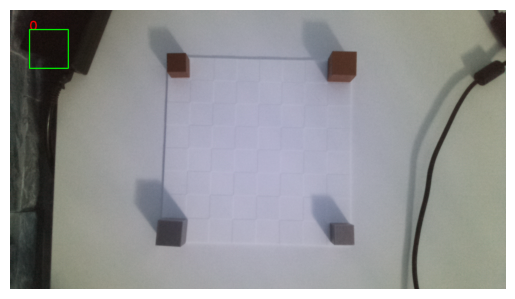

In [6]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Wczytanie zapisanego modelu
model = load_model("efficientnet_model.keras")

# Ścieżka do obrazu, który chcesz przetestować
test_image_path = '/content/images/train/zdjecie1.jpg'

# Wczytanie obrazu
image = cv2.imread(test_image_path)
image_copy = image.copy()  # Skopiowanie obrazu do wyświetlenia predykcji

# Przetwarzanie obrazu
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))
image = np.expand_dims(image, axis=0)  # Dodanie wymiaru wsadowego

# Przewidywanie klas obiektów na obrazie
predictions = model.predict(image)

# Dekodowanie wyników
predicted_classes = np.argmax(predictions, axis=1)

# Wyświetlenie przewidzianych klas na obrazie
font = cv2.FONT_HERSHEY_SIMPLEX
for pred_class in predicted_classes:
    cv2.putText(image_copy, str(pred_class), (50, 50), font, 1, (255, 0, 0), 2, cv2.LINE_AA)
    # Dodanie prostokąta wokół przewidzianego obiektu
    cv2.rectangle(image_copy, (50, 50), (150, 150), (0, 255, 0), 2)

# Wyświetlenie wyniku za pomocą matplotlib
plt.imshow(image_copy)
plt.axis('off')
plt.show()


## Test 2

In [ ]:
import os
import xml.etree.ElementTree as ET
import numpy as np
import cv2
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Funkcja do parsowania pliku XML
def parse_xml_annotation(xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    # Inicjalizacja listy dla opisów obiektów
    annotations = []

    # Iteracja po każdym obiekcie w pliku XML
    for obj in root.findall('object'):
        # Pobranie nazwy klasy obiektu
        class_name = obj.find('name').text

        # Pobranie współrzędnych obrysu obiektu
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        # Dodanie opisu obiektu do listy
        annotations.append({'class_name': class_name,
                            'xmin': xmin,
                            'ymin': ymin,
                            'xmax': xmax,
                            'ymax': ymax})

    return annotations

# Ścieżki do folderów z obrazami treningowymi i walidacyjnymi
train_dir = '/content/images/train'
valid_dir = '/content/images/valid'

# Inicjalizacja list dla danych treningowych i walidacyjnych
train_images = []
train_labels = []
valid_images = []
valid_labels = []

# Wczytanie danych obrazów i ich opisów dla danych treningowych
for image_name in os.listdir(train_dir):
    if image_name.endswith('.jpg'):
        image_path = os.path.join(train_dir, image_name)
        xml_file_path = os.path.join(train_dir, image_name.replace('.jpg', '.xml'))

        # Wczytanie obrazu
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Wczytanie opisów obiektów
        annotations = parse_xml_annotation(xml_file_path)

        # Przetworzenie obrazu
        image = cv2.resize(image, (224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        # Dodanie obrazu i etykiet do listy danych treningowych
        train_images.append(image)
        train_labels.append([annotation['class_name'] for annotation in annotations])

# Konwersja list na tablice numpy
train_images = np.array(train_images, dtype='float32')

# Przekonwertowanie etykiet na wektory "one-hot" za pomocą MultiLabelBinarizer
label_binarizer = MultiLabelBinarizer()
train_labels_encoded = label_binarizer.fit_transform(train_labels)

# Budowa modelu EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Dodanie warstw do wyjścia modelu
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dodanie warstwy Dropout
output = Dense(len(label_binarizer.classes_), activation='softmax')(x)

# Tworzenie końcowego modelu
model = Model(inputs=base_model.input, outputs=output)

# Kompilacja modelu
optimizer = Adam(lr=0.001)  # Zmiana współczynnika uczenia
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Trenowanie modelu
history = model.fit(train_images, train_labels_encoded, epochs=1, batch_size=16)  # Zmiana liczby epok i rozmiaru partii

# Zapis modelu do pliku HDF5
model.save("efficientnet_model.h5")

# Zapis modelu do pliku KERAS
model.save("efficientnet_model.keras")

# Odczytanie danych walidacyjnych
valid_images = []
valid_labels = []

for image_name in os.listdir(valid_dir):
    if image_name.endswith('.jpg'):
        image_path = os.path.join(valid_dir, image_name)
        xml_file_path = os.path.join(valid_dir, image_name.replace('.jpg', '.xml'))

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        valid_images.append(image)
        valid_labels.append([annotation['class_name'] for annotation in parse_xml_annotation(xml_file_path)])

valid_images = np.array(valid_images, dtype='float32')
valid_labels_encoded = label_binarizer.transform(valid_labels)

# Ocena modelu na danych walidacyjnych
valid_predictions = model.predict(valid_images)
valid_predictions_classes = np.argmax(valid_predictions, axis=1)

accuracy = accuracy_score(np.argmax(valid_labels_encoded, axis=1), valid_predictions_classes)
precision = precision_score(np.argmax(valid_labels_encoded, axis=1), valid_predictions_classes, average='weighted')
recall = recall_score(np.argmax(valid_labels_encoded, axis=1), valid_predictions_classes, average='weighted')
f1 = f1_score(np.argmax(valid_labels_encoded, axis=1), valid_predictions_classes, average='weighted')
conf_matrix = confusion_matrix(np.argmax(valid_labels_encoded, axis=1), valid_predictions_classes)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

# Dodanie informacji o etykiecie odczytanej przez model
for i in range(len(valid_images)):
    print("Image:", os.path.basename(valid_dir[i]))
    print("True Label:", valid_labels[i])
    predicted_label = label_binarizer.classes_[valid_predictions_classes[i]]
    print("Predicted Label:", predicted_label)
    print()


In [ ]:
import os
import xml.etree.ElementTree as ET
import numpy as np
import cv2
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Funkcja do parsowania pliku XML
def parse_xml_annotation(xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    # Inicjalizacja listy dla opisów obiektów
    annotations = []

    # Iteracja po każdym obiekcie w pliku XML
    for obj in root.findall('object'):
        # Pobranie nazwy klasy obiektu
        class_name = obj.find('name').text

        # Pobranie współrzędnych obrysu obiektu
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        # Dodanie opisu obiektu do listy
        annotations.append({'class_name': class_name,
                            'xmin': xmin,
                            'ymin': ymin,
                            'xmax': xmax,
                            'ymax': ymax})

    return annotations

# Ścieżki do folderów z obrazami treningowymi i walidacyjnymi
train_dir = '/content/images/train'
valid_dir = '/content/images/valid'

# Inicjalizacja list dla danych treningowych i walidacyjnych
train_images = []
train_labels = []
valid_images = []
valid_labels = []

# Wczytanie danych obrazów i ich opisów dla danych treningowych
for image_name in os.listdir(train_dir):
    if image_name.endswith('.jpg'):
        image_path = os.path.join(train_dir, image_name)
        xml_file_path = os.path.join(train_dir, image_name.replace('.jpg', '.xml'))

        # Wczytanie obrazu
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Wczytanie opisów obiektów
        annotations = parse_xml_annotation(xml_file_path)

        # Przetworzenie obrazu
        image = cv2.resize(image, (224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        # Dodanie obrazu i etykiet do listy danych treningowych
        train_images.append(image)
        train_labels.append([annotation['class_name'] for annotation in annotations])

# Konwersja list na tablice numpy
train_images = np.array(train_images, dtype='float32')

# Przekonwertowanie etykiet na wektory "one-hot" za pomocą MultiLabelBinarizer
label_binarizer = MultiLabelBinarizer()
train_labels_encoded = label_binarizer.fit_transform(train_labels)

# Budowa modelu EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Dodanie warstw do wyjścia modelu
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dodanie warstwy Dropout
output = Dense(len(label_binarizer.classes_), activation='softmax')(x)

# Tworzenie końcowego modelu
model = Model(inputs=base_model.input, outputs=output)

# Kompilacja modelu
optimizer = Adam(lr=0.001)  # Zmiana współczynnika uczenia
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Trenowanie modelu
history = model.fit(train_images, train_labels_encoded, epochs=30, batch_size=10)  # Zmiana liczby epok i rozmiaru partii

# Zapis modelu do pliku HDF5
model.save("efficientnet_model.h5")

# Zapis modelu do pliku KERAS
model.save("efficientnet_model.keras")

# Odczytanie danych walidacyjnych
valid_images = []
valid_labels = []

for image_name in os.listdir(valid_dir):
    if image_name.endswith('.jpg'):
        image_path = os.path.join(valid_dir, image_name)
        xml_file_path = os.path.join(valid_dir, image_name.replace('.jpg', '.xml'))

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        valid_images.append(image)
        valid_labels.append([annotation['class_name'] for annotation in parse_xml_annotation(xml_file_path)])

valid_images = np.array(valid_images, dtype='float32')
valid_labels_encoded = label_binarizer.transform(valid_labels)

# Ocena modelu na danych walidacyjnych
valid_predictions = model.predict(valid_images)
valid_predictions_classes = np.argmax(valid_predictions, axis=1)

accuracy = accuracy_score(np.argmax(valid_labels_encoded, axis=1), valid_predictions_classes)
precision = precision_score(np.argmax(valid_labels_encoded, axis=1), valid_predictions_classes, average='weighted')
recall = recall_score(np.argmax(valid_labels_encoded, axis=1), valid_predictions_classes, average='weighted')
f1 = f1_score(np.argmax(valid_labels_encoded, axis=1), valid_predictions_classes, average='weighted')
conf_matrix = confusion_matrix(np.argmax(valid_labels_encoded, axis=1), valid_predictions_classes)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

# Dodanie informacji o etykiecie odczytanej przez model
for i in range(len(valid_images)):
    image_file = os.path.basename(valid_dir[i]) if isinstance(valid_dir, list) else os.path.basename(valid_dir)
    print("Image:", image_file)
    print("True Label:", valid_labels[i])
    predicted_label = label_binarizer.classes_[valid_predictions_classes[i]]
    print("Predicted Label:", predicted_label)
    print()


## TEST ROZPOZNAWANIA WIELU KLAS NA JEDNYM ZDJĘCIU

In [12]:
import os
import xml.etree.ElementTree as ET
import numpy as np
import cv2
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Funkcja do parsowania pliku XML
def parse_xml_annotation(xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    # Inicjalizacja listy dla opisów obiektów
    annotations = []

    # Iteracja po każdym obiekcie w pliku XML
    for obj in root.findall('object'):
        # Pobranie nazwy klasy obiektu
        class_name = obj.find('name').text

        # Pobranie współrzędnych obrysu obiektu
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        # Dodanie opisu obiektu do listy
        annotations.append({'class_name': class_name,
                            'xmin': xmin,
                            'ymin': ymin,
                            'xmax': xmax,
                            'ymax': ymax})

    return annotations

# Ścieżki do folderów z obrazami treningowymi i walidacyjnymi
train_dir = '/content/images/train'
valid_dir = '/content/images/valid'

# Inicjalizacja list dla danych treningowych i walidacyjnych
train_images = []
train_labels = []
valid_images = []
valid_labels = []

# Wczytanie danych obrazów i ich opisów dla danych treningowych
for image_name in os.listdir(train_dir):
    if image_name.endswith('.jpg'):
        image_path = os.path.join(train_dir, image_name)
        xml_file_path = os.path.join(train_dir, image_name.replace('.jpg', '.xml'))

        # Wczytanie obrazu
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Wczytanie opisów obiektów
        annotations = parse_xml_annotation(xml_file_path)

        # Przetworzenie obrazu
        image = cv2.resize(image, (224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        # Dodanie obrazu i etykiet do listy danych treningowych
        train_images.append(image)
        train_labels.append([annotation['class_name'] for annotation in annotations])

# Konwersja list na tablice numpy
train_images = np.array(train_images, dtype='float32')

# Przekonwertowanie etykiet na wektory "one-hot" za pomocą MultiLabelBinarizer
label_binarizer = MultiLabelBinarizer()
train_labels_encoded = label_binarizer.fit_transform(train_labels)

# Budowa modelu EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Dodanie warstw do wyjścia modelu
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dodanie warstwy Dropout
output = Dense(len(label_binarizer.classes_), activation='sigmoid')(x)

# Tworzenie końcowego modelu
model = Model(inputs=base_model.input, outputs=output)

# Kompilacja modelu
optimizer = Adam(learning_rate=0.001)  # Zmiana współczynnika uczenia
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Trenowanie modelu
history = model.fit(train_images, train_labels_encoded, epochs=5, batch_size=10)  # Zmiana liczby epok i rozmiaru partii

# Zapis modelu do pliku HDF5
model.save("efficientnet_model.h5")

# Zapis modelu do pliku KERAS
model.save("efficientnet_model.keras")

# Odczytanie danych walidacyjnych
for image_name in os.listdir(valid_dir):
    if image_name.endswith('.jpg'):
        image_path = os.path.join(valid_dir, image_name)
        xml_file_path = os.path.join(valid_dir, image_name.replace('.jpg', '.xml'))

        # Wczytanie obrazu
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Wczytanie opisów obiektów
        annotations = parse_xml_annotation(xml_file_path)

        # Przetworzenie obrazu
        image = cv2.resize(image, (224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        # Przewidywanie etykiet dla obrazu
        predictions = model.predict(np.expand_dims(image, axis=0))
        predicted_labels = label_binarizer.classes_[predictions[0] > 0.5]  # Próg 0.5

        # Wypisanie wyników
        print("Image:", image_name)
        print("True Label:", [annotation['class_name'] for annotation in annotations])
        print("Predicted Label:", predicted_labels)
        print()


Epoch 1/5
20/20 [==============================] - 76s 3s/step - loss: 0.0464 - accuracy: 0.6100
Epoch 2/5
20/20 [==============================] - 52s 3s/step - loss: 1.3528e-04 - accuracy: 0.7350
Epoch 3/5
20/20 [==============================] - 49s 2s/step - loss: 3.1570e-05 - accuracy: 0.7500
Epoch 4/5
20/20 [==============================] - 49s 2s/step - loss: 1.1846e-06 - accuracy: 0.7050
Epoch 5/5
20/20 [==============================] - 48s 2s/step - loss: 8.9439e-07 - accuracy: 0.6850


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 2s 2s/step
Image: zdjecie283.jpg
True Label: ['GREY', 'GREY', 'BLUE', 'BLUE']
Predicted Label: ['BLUE' 'GREY']

1/1 [==============================] - 0s 84ms/step
Image: zdjecie299.jpg
True Label: ['GREY', 'GREY', 'BLUE', 'BLUE']
Predicted Label: ['BLUE' 'GREY']

1/1 [==============================] - 0s 87ms/step
Image: zdjecie309.jpg
True Label: ['BLUE', 'BLUE', 'GREY', 'GREY']
Predicted Label: ['BLUE' 'GREY']

1/1 [==============================] - 0s 81ms/step
Image: zdjecie263.jpg
True Label: ['GREY', 'GREY', 'BLUE', 'BLUE']
Predicted Label: ['BLUE' 'GREY']

1/1 [==============================] - 0s 83ms/step
Image: zdjecie257.jpg
True Label: ['BLUE', 'BLUE', 'GREY', 'GREY']
Predicted Label: ['BLUE' 'GREY']

1/1 [==============================] - 0s 87ms/step
Image: zdjecie262.jpg
True Label: ['BLUE', 'BLUE', 'GREY', 'GREY']
Predicted Label: ['BLUE' 'GREY']

1/1 [==============================] - 0s 138ms/step
Image: zdjecie258.jpg
True Labe